## Bayesian Modeling

In [2]:
import pandas as pd
import numpy as np

from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

### Google Trend for "artificial intelligence"

In [4]:
google = pd.read_csv("data/google_trend_ai.csv")
google.sample(10)

,Week,artificial intelligence: (United States)
21,2018-09-30,34
46,2019-03-24,36
105,2020-05-10,29
200,2022-03-06,30
93,2020-02-16,35
225,2022-08-28,31
38,2019-01-27,35
199,2022-02-27,29
71,2019-09-15,35
213,2022-06-05,26


In [94]:
Y_train = np.array(google.iloc[:-5,1])

k = 1                                             
forecast_start = 15
forecast_end = len(Y_train)-1

In [95]:
mod, samples = analysis(Y_train, family="normal",
                        forecast_start=forecast_start,      # First time step to forecast on
                        forecast_end=forecast_end,          # Final time step to forecast on
                        ntrend = 2,                        
                        k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
                        nsamps = 1000,                        
                        prior_length=10,                     # How many data point to use in defining prior
                        rho=.5,
                        deltrend = 0.95
)

beginning forecasting


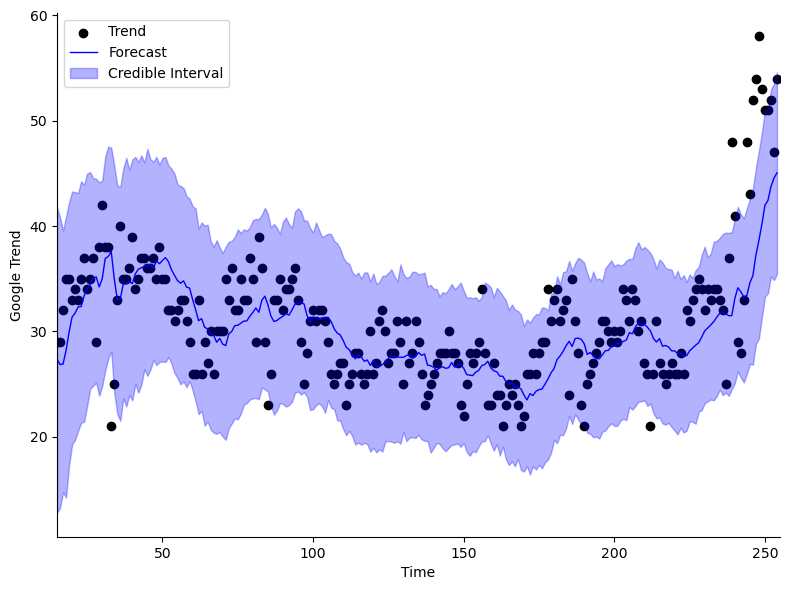

In [96]:
import matplotlib.pyplot as plt

# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y_train[forecast_start: forecast_end+k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+k, dtype='int'))
ax = ax_style(ax, ylabel='Google Trend', xlabel='Time', xlim=[forecast_start, forecast_end+k],
              legend=['Trend', 'Forecast', 'Credible Interval'])

In [97]:
pred_samples = mod.forecast_path(k=5, nsamps = 1000)
pred = median(pred_samples)

In [14]:
np.mean(np.square(pred - google.iloc[-5:,1]))

1265.03673278817

In [98]:
pred

array([45.91859709, 46.56241817, 46.5522941 , 46.7268302 , 47.22626531])

### Rainfall

In [24]:
precip = pd.read_csv("data/CSVDataServlet.txt")
precip.head()

,STATION_ID,DURATION,SENSOR_NUMBER,SENSOR_TYPE,DATE TIME,OBS DATE,VALUE,DATA_FLAG,UNITS
0,TLD,E,16,RAINTIP,20180501 0000,20180501 0000,31.21,,INCHES
1,TLD,E,16,RAINTIP,20180501 0100,20180501 0100,31.21,,INCHES
2,TLD,E,16,RAINTIP,20180501 0200,20180501 0200,31.21,,INCHES
3,TLD,E,16,RAINTIP,20180501 0300,20180501 0300,31.21,,INCHES
4,TLD,E,16,RAINTIP,20180501 0400,20180501 0400,31.21,,INCHES


In [59]:
precip["Month"] = precip["DATE TIME"].str[:6]
precip.groupby("Month").mean("VALUE")

,SENSOR_NUMBER,VALUE
Month,,
201805,16.0,31.300599
201806,16.0,31.512274
201807,16.0,0.107185
201808,16.0,0.120000
201809,16.0,0.120000
...,...,...
202301,16.0,27.748451
202302,16.0,34.744388
202303,16.0,43.610162


In [31]:
precip["Day"] = precip["DATE TIME"].str[:9]
precipitation = precip.groupby("Day").mean()["VALUE"].to_frame()
precipitation

,VALUE
Day,
20180501,31.210000
20180502,31.210000
20180503,31.218333
20180504,31.220000
20180505,31.220000
...,...
20230427,50.030000
20230428,50.030000
20230429,50.030000


In [99]:
k = 1                                             
forecast_start = 15
forecast_end = len(Y_train)-1

seasPeriods=[365]
seasHarmComponents = [[1,2,3]]

Y_train = np.array(precipitation["VALUE"].iloc[:-30])

In [100]:
mod, samples = analysis(Y_train, family="normal",
                        forecast_start=forecast_start,      # First time step to forecast on
                        forecast_end=forecast_end,          # Final time step to forecast on
                        ntrend = 2,                        
                        k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
                        nsamps = 1000,                        
                        prior_length=10,                     # How many data point to use in defining prior
                        rho=.5,
                        deltrend = 0.95,
                        seasPeriods=seasPeriods, 
                        seasHarmComponents=seasHarmComponents,
)

beginning forecasting


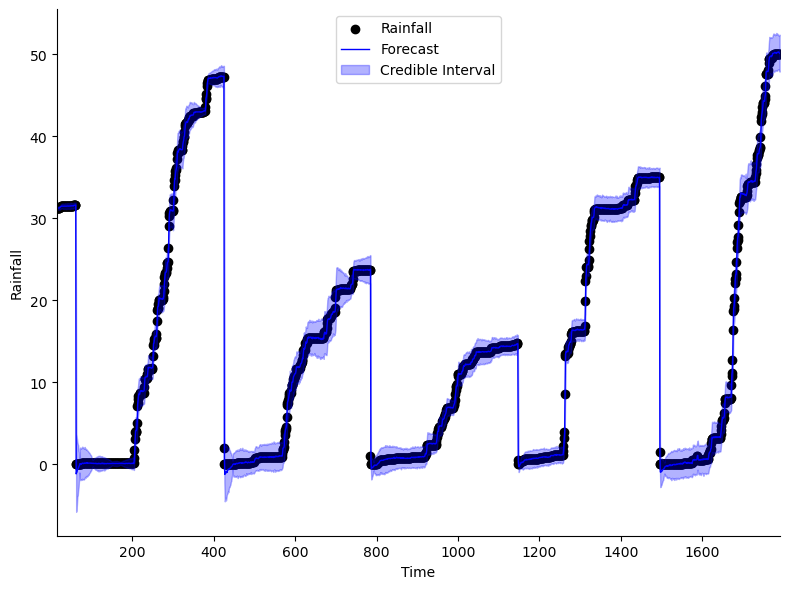

In [92]:
import matplotlib.pyplot as plt

# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y_train[forecast_start: forecast_end+k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+k, dtype='int'))
ax = ax_style(ax, ylabel='Rainfall', xlabel='Time', xlim=[forecast_start, forecast_end+k],
              legend=['Rainfall', 'Forecast', 'Credible Interval'])

In [101]:
pred_samples = mod.forecast_path(k=30, nsamps = 1000)
pred = median(pred_samples)

In [103]:
np.mean(np.square(pred - np.array(precipitation.iloc[-30:]).flatten()))

21.53516130063131

### S&P 500

In [27]:
stock = pd.read_csv("data/HistoricalData_1683073126605.csv")
sp = stock[["Date", "Close/Last"]]
sp = sp.iloc[::-1]
sp["Standardized"] = (sp["Close/Last"] - sp["Close/Last"].mean())/sp["Close/Last"].std()
sp.head()

,Date,Close/Last,Standardized
1257,05/02/2018,2635.67,-1.378725
1256,05/03/2018,2629.73,-1.387819
1255,05/04/2018,2663.42,-1.336240
1254,05/07/2018,2672.63,-1.322140
1253,05/08/2018,2671.92,-1.323227


In [44]:
Y_train = np.array(sp["Standardized"].iloc[:-20])
k = 1                                             
forecast_start = 15
forecast_end = len(Y_train)-1
seasPeriods=[5]
seasHarmComponents = [[1,2,3]]

In [45]:
mod, samples = analysis(Y_train, family="normal",
                        forecast_start=forecast_start,      # First time step to forecast on
                        forecast_end=forecast_end,          # Final time step to forecast on
                        ntrend = 2,                        
                        k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
                        nsamps = 1000,                        
                        prior_length=10,                     # How many data point to use in defining prior
                        rho=.5,
                        deltrend = 0.95,
                        seasPeriods=seasPeriods, 
                        seasHarmComponents=seasHarmComponents,
)

beginning forecasting


In [51]:
pred_samples = mod.forecast_path(k=20, nsamps = 1000)
pred = median(pred_samples)

In [52]:
pred_origin = pred * sp["Close/Last"].std() + sp["Close/Last"].mean()

In [53]:
np.mean(np.square(pred_origin - np.array(sp.iloc[-20:,1]).flatten()))

17116.404449188638